In [1]:
#V.1

import matplotlib.pyplot as plt
import pandas as pd

white_df = pd.read_csv("resources/winequality-white.csv", sep=";")
red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 

def plot_scatter_matrix(wine_data: pd.DataFrame, good_threshold: int, bad_threshold: int, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce graphs which shows dependence between
    every two factors.
    """
    assert good_threshold > bad_threshold, "Please, enter good_treshold sctrictly > than bad_treshold"
    q = wine_data['quality']    

    labels = wine_data.columns[:-1]
    assert len(labels) >=2, "there have to be at least 2 labels ti build dependence"
    f, axarr = plt.subplots(len(labels), len(labels), figsize=(20, 20))
    f.suptitle('Dependence between acidity and quality')
    f.subplots_adjust(wspace=0, hspace=0)

    k = 0
    for x in [wine_data[label] for label in labels]:
        j = 0
        for y in [wine_data[label] for label in labels]:
            axarr[k][j].set_xticks([])
            axarr[k][j].set_yticks([])
            if k == j:
                axarr[k][j].text(0.1, 0.5, labels[k], fontsize=11)
            else:
                colors = [('orchid' if q[i]<= bad_threshold else ('green' if q[i]>=good_threshold else 'None'))\
                          for i in range(wine_data.shape[0])]
                axarr[k][j].scatter(x, y, marker='.', c=colors)
            j+=1
        k+=1
    plt.savefig('fig.png') if save_plot else 0
    return
        
    
plot_scatter_matrix(red_df, 8, 3, False)

# Important chemical factors: volatile acidity, sulfates, alcohol. 
# Basically we can divide almost strictly bad and good wines considering them.

In [2]:
def feature_scaling(x: pd.DataFrame):
    print('Feature scaling is on.')
    means, maxs, mins = {}, {}, {}
    for feature in x.columns[:-1]:
        means[feature] = sum(x[feature]) / len(x[feature])
        maxs[feature] = max(x[feature])
        mins[feature] = min(x[feature])
    
    scaled_x = x.copy(deep=True)
    for feature in scaled_x.columns[:-1]:
        for j in range(len(scaled_x[feature])):
            scaled_x.loc[j, feature] = (x[feature][j] - means[feature]) / (maxs[feature] - mins[feature])
    print('Data scaled.')
    return scaled_x


Feature scaling is on.
Data scaled.


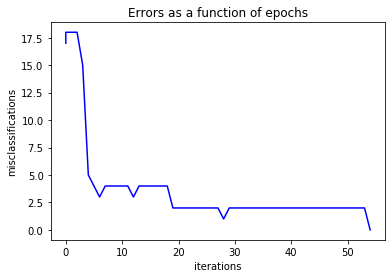

b = 8.060134058041815, w1 = 1.3393424130387082, w2 = -1.3542718974141663, x2 = 0.04-x1*-0.99


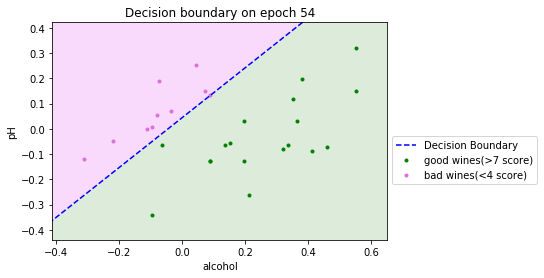

In [48]:
# V.2

import random
random.seed(1777)


def inf():
    i = 0
    while True:
        yield i
        i += 1

def dot(a: list, b: list) -> float:
    """
    Scalar product of 2 vectors a and b
    """
    assert len(a) == len(b), "Vectors must be equal length!"
    return sum([a[i] * b[i] for i in range(len(a))])

class Perceptron(object):

    def __init__(self, threshold, learning_rate =0.4, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs 
        self.res = []
        self.threshold = threshold
        return

    def error(self, y: list, d: list) -> int:
        return sum(abs(d-y))

    
    def train(self, x: list, d: list): 
        """
        train perceptron on received data
        x - received data (matrix, row - one specific wine)
        d - desired output (good(1) or bad(0) wines good=(quality>threshold))
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        self.w = [random.random() for i in range(len(x[0]))] # x1w1 + x2w2 + b = threshold 
        self.bias = random.random()
        y = [int(random.random() > 0.5) for _ in range(len(x))]
        self.res.append([0, self.error(y, d), self.w, self.bias])
        for i in inf() if self.epochs == 0 else range(self.epochs):
            for row in range(len(x)):
                y[row] = int(dot(x[row], self.w) + self.bias >= self.threshold)
                error = d[row] - y[row]
                for col in range(len(x[row])):
                    self.w[col] += self.learning_rate * error * x[row][col]
                self.bias += self.learning_rate * error
            self.res.append([i, self.error(y, d), self.w, self.bias])
            if self.epochs == 0 and self.res[-1][1] == 0:
                break
        return

pink, green = (0.976, 0.854, 0.992), (0.866, 0.921, 0.854)
def plot_performance(performance, wine_data, good_thresh, bad_thresh, factors: list, epoch=-1, save_plot=False):
    """
    Plot the performance of our perceptron or adaline.
    this function will produce a two plot figure:
    1) Classification Errors vs. Epochs
    2) Decision boundary for two factors
    """
    if epoch < 0 or epoch > performance[-1][0]:
        print(f'epoch was : {epoch}')
        epoch = performance[-1][0]
    plt.figure(1)
    errors = [performance[i][1]  for i in range(len(performance))]
    epochs = [performance[i][0]  for i in range(len(performance))]
    plt.plot(epochs, errors, c='b')
    plt.xlabel('iterations')
    plt.ylabel('misclassifications')
    plt.title('Errors as a function of epochs')
    plt.show()

    b = performance[epoch][3]
    w1 = performance[epoch][2][0]
    w2 = performance[epoch][2][1]
    assert w2 != 0, "w2 = 0"
    print(f'b = {b}, w1 = {w1}, w2 = {w2}, x2 = {round((good_thresh - b)/w2,2)}-x1*{round(w1/w2,2)}') # x1w1 + x2w2 + b =8
    f1 = [i for i in range(-50, 50)]
    f2 = [ (good_thresh - b - w1 * f1[j]) / w2 for j in range(len(f1))]
    plt.figure(2)
    plt.xlim(min(wine_data[factors[0]].values)-0.1, max(wine_data[factors[0]].values)+0.1)
    plt.ylim(min(wine_data[factors[1]].values)-0.1, max(wine_data[factors[1]].values)+0.1)
    plt.plot(f1, f2, linestyle='--', color='b', label='Decision Boundary')
   
    goods = wine_data[wine_data.quality >= good_thresh]
    bads = wine_data[wine_data.quality <= bad_thresh]
    xg, yg = goods[factors[0]].values, goods[factors[1]].values
    xb, yb = bads[factors[0]].values, bads[factors[1]].values

    # count good dots and define how to fill the field
    right_color, left_color = green, pink
    upper_dots = 0
    for xi, yi in zip(xb, yb):
        if (good_thresh - b - w1 * xi) / w2 < yi:
            upper_dots += 1
    if upper_dots > len(xb) / 2:
        right_color, left_color = pink, green
    

    plt.fill_between(f1, f2, max(f1)+5, facecolor=right_color)
    plt.fill_between(f1, f2, min(f1)-5, facecolor=left_color)
    plt.scatter(xg, yg, marker='.', c='green', label=f'good wines(>{good_thresh-1} score)')
    plt.scatter(xb, yb, marker='.', c='orchid', label=f'bad wines(<{bad_thresh+1} score)')
    plt.title(f'Decision boundary on epoch {epoch}')
    plt.xlabel(factors[0]) 
    plt.ylabel(factors[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    return

def prepare_data_and_train(wine_data: pd.DataFrame, learning_rate, \
                           factors: list, wines_threshs: list, epochs: int):
    perceptron = Perceptron(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality <= wines_threshs[0]) | (wine_data.quality >= wines_threshs[1])]
    part.index = range(len(part))
    x = part[factors].values
    d = (part['quality'] >= wines_threshs[1]).astype(int)
    perceptron.train(x, d)
    plot_performance(perceptron.res, part, wines_threshs[1], wines_threshs[0], factors, perceptron.res[-1][0])
    return


red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 
# prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 0)

# feature scaling
red_df = feature_scaling(red_df)
prepare_data_and_train(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 0)

# prepare_data_and_train(red_df, 0.1, ['chlorides', 'sulphates'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['volatile acidity', 'alcohol'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.01, ['density', 'volatile acidity'], [3, 8], 10000)
# prepare_data_and_train(red_df, 0.1, ['density', 'volatile acidity'], [3, 8], 10000)

# V.2 end

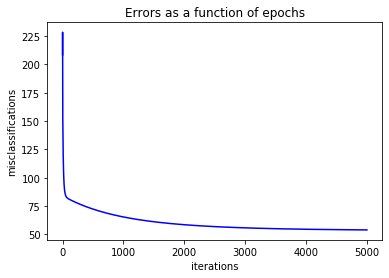

b = 10.220677225806092, w1 = 1.3167142507654643, w2 = -5.109644674941235, x2 = 0.43-x1*-0.26


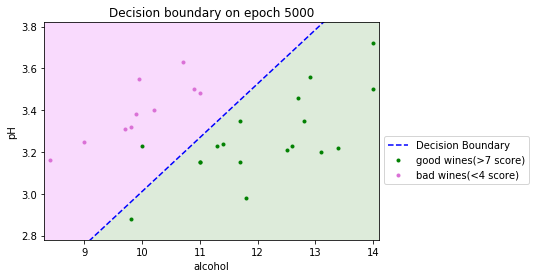

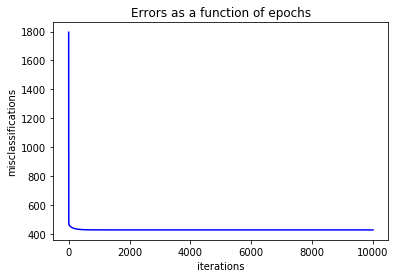

b = 4.719048663921578, w1 = 0.7209832024679843, w2 = -2.0033946595148073, x2 = -1.14-x1*-0.36


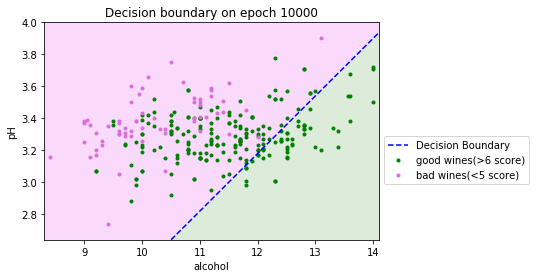

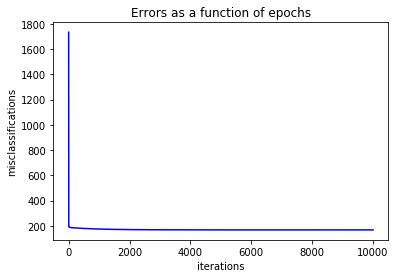

b = 7.437859931170446, w1 = 0.6975861098324359, w2 = -2.6231298100676237, x2 = 0.17-x1*-0.27


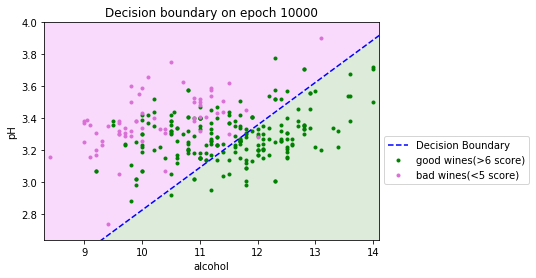

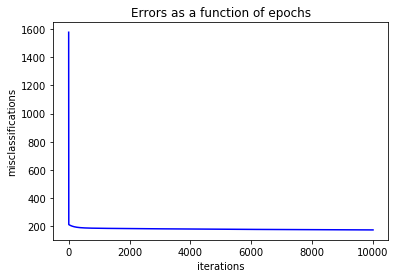

b = 4.056465662692153, w1 = 0.7366922030327498, w2 = -1.8410159911749535, x2 = -1.6-x1*-0.4


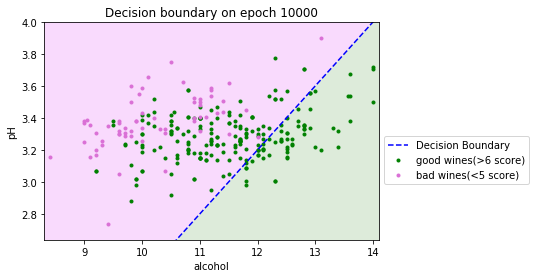

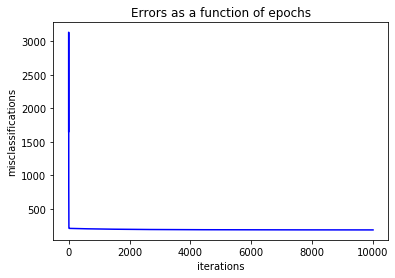

b = 0.4432677702221915, w1 = 0.7908569172227594, w2 = -0.9062882054527711, x2 = -7.23-x1*-0.87


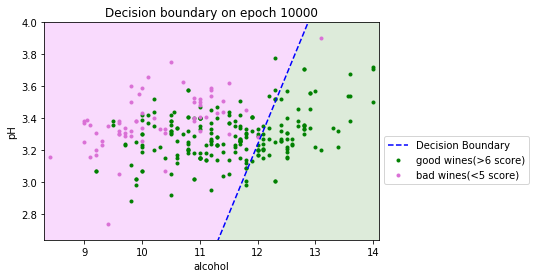

In [69]:
# V.3

red_df = pd.read_csv("resources/winequality-red.csv", sep=";") 
class Adaline(object):

    def __init__(self, threshold, learning_rate=0.01, epochs=0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.res = []
        self.current_epoch = 0
        self.threshold = threshold
        self.w = []
        return
 
    def error(self, y: list, d: list) -> float:
        r = 0
        for i in range(len(d)):
            r += (d[i] - y[i]) * (d[i] - y[i])
        r = r / 2
        return r

    def do_step_batch(self, x, y, d):
        """
        update weights for each row once (batch)
        """
        updates = [0 for i in range(len(x[0]))]
        bias_update = 0
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
            for col in range(len(x[row])):
                updates[col] += self.learning_rate * error * x[row][col]
            bias_update += self.learning_rate * error
        self.bias +=  bias_update
        for col in range(len(x[row])):
            self.w[col] += updates[col]
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
    
    def do_step_online(self, x, y, d):
        """
        update weights for each row once (batch)
        """        
        for row in range(len(x)):
            y[row] = dot(x[row], self.w) + self.bias
            error = d[row] - y[row]
#             print(f'error = {error}')
            for col in range(len(x[row])):
                self.w[col] += self.learning_rate * error * x[row][col]
            self.bias += self.learning_rate * error
        self.current_epoch +=1
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        return
          
    def train(self, x: list, d: list, online=True, reinitialize_weights=True):
        """
        train adaline on received data
        x - received data (matrix, row - one specific wine)
        d - desired output
        """
        assert (len(x) == len(d)), "x should have the same amount of rows as d"
        if len(self.w) != len(x[0]) or reinitialize_weights:
            self.w = [random.random() for i in range(len(x[0]))]
            self.bias = random.random()
        y = [random.random() * 10 for _ in range(len(x))]
        self.res.append([self.current_epoch, self.error(y, d), self.w, self.bias])
        step = self.do_step_online if online else self.do_step_batch
        for i in inf() if self.epochs == 0 else range(self.epochs):
#             print(f'w = {self.w}')
            step(x, y, d)
            if self.epochs == 0 and i > 2 and abs(self.res[-2][1]) < abs(self.res[-1][1]):
                break
        return
    
    def predict(self, x):
        return dot(self.w, x) + self.bias
    
    
def prepare_data_and_train_ada(wine_data: pd.DataFrame, learning_rate, \
                               factors: list, wines_threshs: list, epochs: int, online=True):
    ada = Adaline(wines_threshs[1], learning_rate, epochs)
    part = wine_data[(wine_data.quality >= wines_threshs[1]) | (wine_data.quality <= wines_threshs[0])]
    part.index = range(len(part))
    x = part[factors].values
    d = part['quality']
    ada.train(x, d, online)
    plot_performance(ada.res, part, wines_threshs[1], wines_threshs[0], factors, ada.current_epoch)
    return


# learning_rate, online = 0.01, False # batch
learning_rate, online = 0.01, True #online

# showtime
# prepare_data_and_train_ada(red_df, 0.1, ['alcohol', 'pH'], [3, 8], 4)
# prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [3, 8], 4)
# prepare_data_and_train_ada(red_df, 0.0001, ['alcohol', 'pH'], [3, 8], 4)

prepare_data_and_train_ada(red_df, learning_rate, ['alcohol', 'pH'], [3, 8], 5000, online)
prepare_data_and_train_ada(red_df, 0.01, ['alcohol', 'pH'], [4, 7], 10000, online)
prepare_data_and_train_ada(red_df, 0.001, ['alcohol', 'pH'], [4, 7], 10000, online)
prepare_data_and_train_ada(red_df, 0.0001, ['alcohol', 'pH'], [4, 7], 10000, online)
prepare_data_and_train_ada(red_df, 0.00001, ['alcohol', 'pH'], [4, 7], 10000, online)



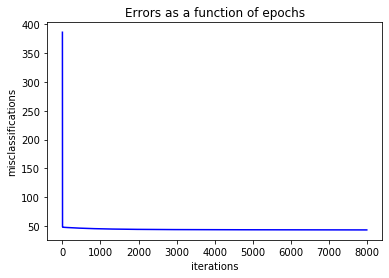

b = 1.0070256148922598, w1 = -1.0911923996632251, w2 = 0.7885791653468431, x2 = 7.6-x1*-1.38


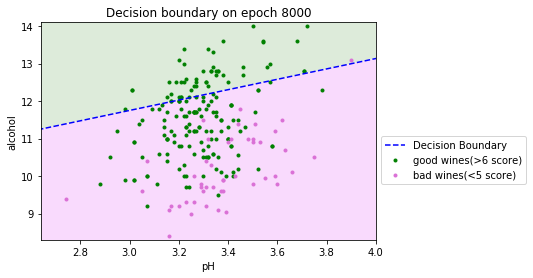

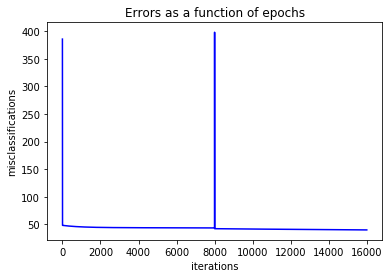

b = 2.3109911237486065, w1 = -1.2401574502771013, w2 = 0.740521334663824, x2 = 6.33-x1*-1.67


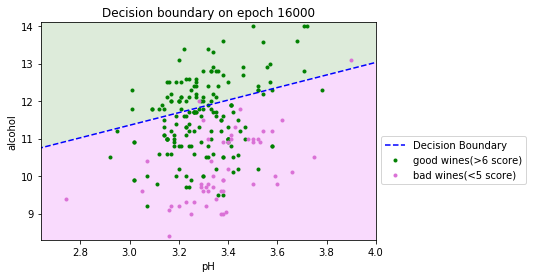

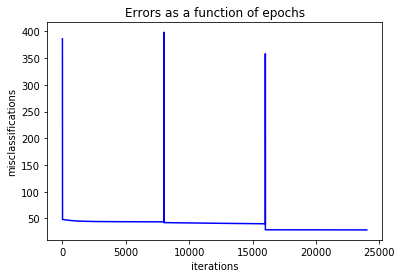

b = 2.7194030370748026, w1 = -1.2831911536317737, w2 = 0.6896169978700423, x2 = 6.21-x1*-1.86


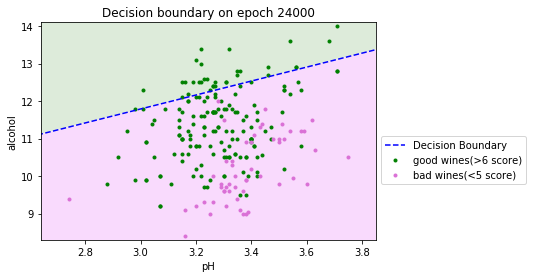

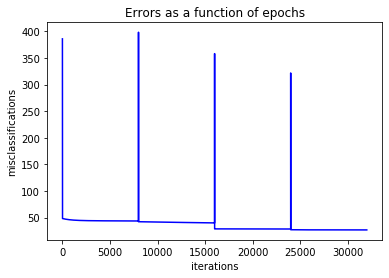

b = 2.9351925422628122, w1 = -1.6336279301469443, w2 = 0.8024349444252076, x2 = 5.07-x1*-2.04


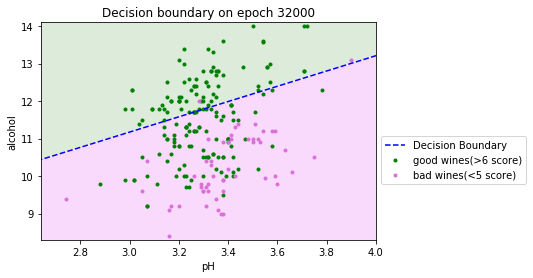

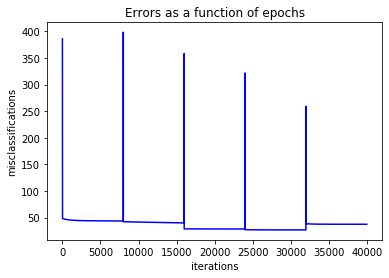

b = 3.1248459513836178, w1 = -2.1690032586169807, w2 = 0.9191304675685931, x2 = 4.22-x1*-2.36
mean: w = -2.1690032586169807 w2 = 0.9191304675685931, bias = 0.61406504655299


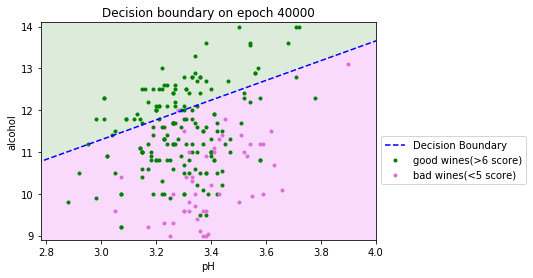

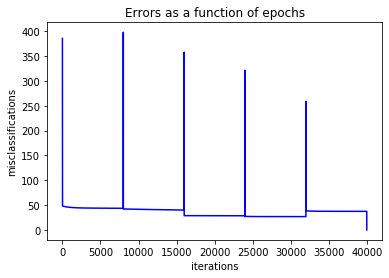

b = 3.124882674693978, w1 = -2.1690032586169807, w2 = 0.9191304675685931, x2 = 4.22-x1*-2.36


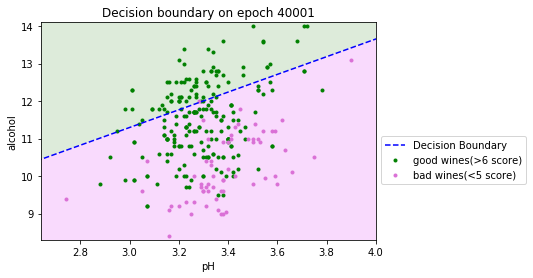

In [77]:
# V.4

def holdout(wine_data: pd.DataFrame, limits, train_part=0.8):
    wine_data = wine_data[(wine_data.quality >= limits[1]) | (wine_data.quality <= limits[0])]
    train_amount = int(wine_data.shape[0] * train_part)
    shuffled_data = wine_data.sample(frac=1)
    return (shuffled_data[:train_amount], shuffled_data[train_amount:])

# (training_df, validation_df) = holdout(red_df, [4, 7])
# ada = Adaline(8, 0.01, 10000)
# tr, val = training_df[training_df.quality.isin([3, 8])], validation_df[validation_df.quality.isin([3, 8])]
# tr.index, val.index = range(len(tr)), range(len(val))
# x, val_x = tr[['pH', 'alcohol']].values, val[['pH', 'alcohol']].values
# d, val_d = tr['quality'], val['quality']
# ada.train(x, d)
# for j in range(len(val_x)):
#     print(f'prediction i = {j} : {ada.predict(val_x[j])}, error = {val_d[j] - ada.predict(val_x[j])}')



def k_fold(wine_data: pd.DataFrame, k=3, shuffle=False):
    wine_data = wine_data[(wine_data.quality <= 4) | (wine_data.quality >= 7)]
    if shuffle:
        wine_data = wine_data.sample(frac=1, random_state=1, axis=0)
    folds = []
    rest = wine_data
    amount = int(wine_data.shape[0] / k)
    res = []
    for i in range(k-1):
        training_temp = rest.sample(n=amount)
        folds.append(training_temp)
        rest = rest.drop(training_temp.index) 
        res.append([folds[i], wine_data.drop(folds[i].index)]) # (trainig, validation)
    res.append([rest, wine_data.drop(rest.index)]) # (trainig, validation)
    return res


def training(data, k):
    tuples = k_fold(data, k)
    weight_list = [] # tuples [w, bias]
    ada = Adaline(7, 0.0001, 8000)
    
    for t in tuples:
        tr, val = t[0], t[1]
        tr.index, val.index = range(len(tr)), range(len(val))
        x = tr[['pH', 'alcohol']].values
        d = tr['quality']
        ada.train(x, d, True, False)
        plot_performance(ada.res, val, 7, 4, ['pH', 'alcohol'], ada.current_epoch)
        weight_list.append([ada.res[-1][2], ada.res[1][3]])
        
    weight1 = sum([x[0][0] for x in weight_list]) / k
    weight2 = sum([x[0][1] for x in weight_list]) / k
    bias = sum([x[1] for x in weight_list]) / k
    print(f'mean: w = {weight1} w2 = {weight2}, bias = {bias}')
    ada.res.append([ada.res[-1][0]+1, 0, [weight1, weight2], bias])
    part = data[(data.quality >= 7) | (data.quality <= 4)]
    plot_performance(ada.res, part, 7, 4, ['pH', 'alcohol'], ada.current_epoch + 1)

training(red_df, 5)
    